In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [327]:
data_filepath = './../data/price_elasticity_data.csv'

In [328]:
df = pd.read_csv(data_filepath)
df.head()

,Product,Menu_Price,Pizza_Count,Profit_Percentage
0,Individuale,4.8200,6.583538,25.263382
1,Individuale,5.2500,6.763684,26.845586
2,Individuale,5.7500,6.690481,30.214454
3,Individuale,6.2275,6.138780,33.417930
4,Individuale,6.5500,5.977077,35.425975


In [329]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Product            156 non-null    object 
 1   Menu_Price         156 non-null    float64
 2   Pizza_Count        156 non-null    float64
 3   Profit_Percentage  156 non-null    float64
dtypes: float64(3), object(1)
memory usage: 5.0+ KB


summary statistics

check for null values

In [330]:
df.isnull().sum()

Product              0
Menu_Price           0
Pizza_Count          0
Profit_Percentage    0
dtype: int64

min, max and average price

In [331]:
# Calculate summary statistics for each product
individuale_stats = df[df['Product'] == 'Individuale']['Menu_Price'].agg(['min', 'mean', 'max'])
print("Individuale Price Statistics:")
print(individuale_stats)

Individuale Price Statistics:
min      4.820000
mean     9.162289
max     18.610000
Name: Menu_Price, dtype: float64


In [332]:
communita_stats = df[df['Product'] == 'Communita']['Menu_Price'].agg(['min', 'mean', 'max'])
print("\nCommunita Price Statistics:")
print(communita_stats)


Communita Price Statistics:
min      7.250000
mean    12.886706
max     25.640000
Name: Menu_Price, dtype: float64


# EDA



## Calculate the Cost Price

In [333]:
df['Cost'] = df['Menu_Price'] * (1 - df['Profit_Percentage'] / 100)

## Calculate the Total Profit in Dollars

In [334]:
df['Profit_Dollars'] = (df['Menu_Price'] - df['Cost']) * df['Pizza_Count']

# Calculate the Cost of Goods Sold (COGS)

In [335]:
df['COGS'] = df['Cost'] * df['Pizza_Count']

In [336]:
# Display the first few rows to check the calculations
df.head()

,Product,Menu_Price,Pizza_Count,Profit_Percentage,Cost,Profit_Dollars,COGS
0,Individuale,4.8200,6.583538,25.263382,3.602305,8.016741,23.715912
1,Individuale,5.2500,6.763684,26.845586,3.840607,9.532690,25.976650
2,Individuale,5.7500,6.690481,30.214454,4.012669,11.623581,26.846686
3,Individuale,6.2275,6.138780,33.417930,4.146398,12.775426,25.453829
4,Individuale,6.5500,5.977077,35.425975,4.229599,13.869217,25.280635


In [337]:
# Calculate the total profit and COGS for each product
profit_and_cogs = df.groupby('Product').agg({
    'Profit_Dollars': 'sum',
    'COGS': 'sum'
}).reset_index()
profit_and_cogs

,Product,Profit_Dollars,COGS
0,Communita,1581.318418,2033.476761
1,Individuale,1518.688013,1782.031348


In [338]:
df.describe()

,Menu_Price,Pizza_Count,Profit_Percentage,Cost,Profit_Dollars,COGS
count,156.000000,156.000000,156.000000,156.000000,156.000000,156.000000
mean,11.191619,4.146149,44.027780,6.179894,19.871836,24.458385
std,2.896829,0.955067,5.621886,1.364508,5.445146,1.983708
min,4.820000,2.987975,24.943828,3.602305,6.153123,18.514794
25%,9.182500,3.320628,41.745722,4.933282,16.677687,23.541803
50%,10.970000,3.449850,45.143602,6.602432,19.704164,24.010418
75%,13.005000,5.024301,47.848259,7.206601,23.040337,25.283202
max,25.640000,6.763684,55.887913,12.623639,44.501129,37.719122


In [339]:
# Calculate skewness and kurtosis
summary_stats = df.describe().T
numerical_cols = df.select_dtypes(include='number').columns
summary_stats['skewness'] = df[numerical_cols].skew()
summary_stats['kurtosis'] = df[numerical_cols].kurtosis()
summary_stats

,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Menu_Price,156.0,11.191619,2.896829,4.820000,9.182500,10.970000,13.005000,25.640000,0.872685,2.985534
Pizza_Count,156.0,4.146149,0.955067,2.987975,3.320628,3.449850,5.024301,6.763684,0.491675,-1.057726
Profit_Percentage,156.0,44.027780,5.621886,24.943828,41.745722,45.143602,47.848259,55.887913,-1.146956,1.545031
Cost,156.0,6.179894,1.364508,3.602305,4.933282,6.602432,7.206601,12.623639,0.586377,1.525599
Profit_Dollars,156.0,19.871836,5.445146,6.153123,16.677687,19.704164,23.040337,44.501129,0.595995,2.668410
COGS,156.0,24.458385,1.983708,18.514794,23.541803,24.010418,25.283202,37.719122,2.721894,17.419374


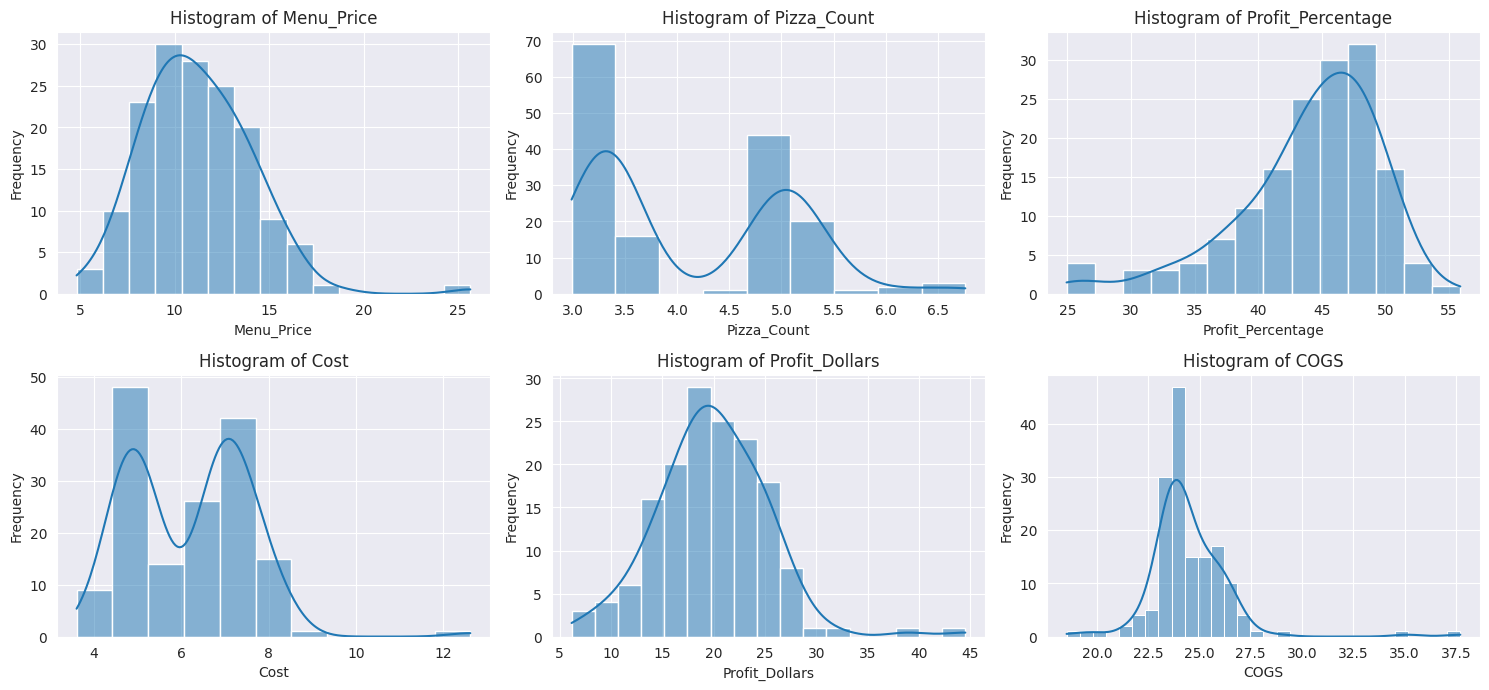

In [340]:
# Visualize the distribution, skewness, kurtosis, and outliers
plt.figure(figsize=(15, 10))

# Histograms
for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

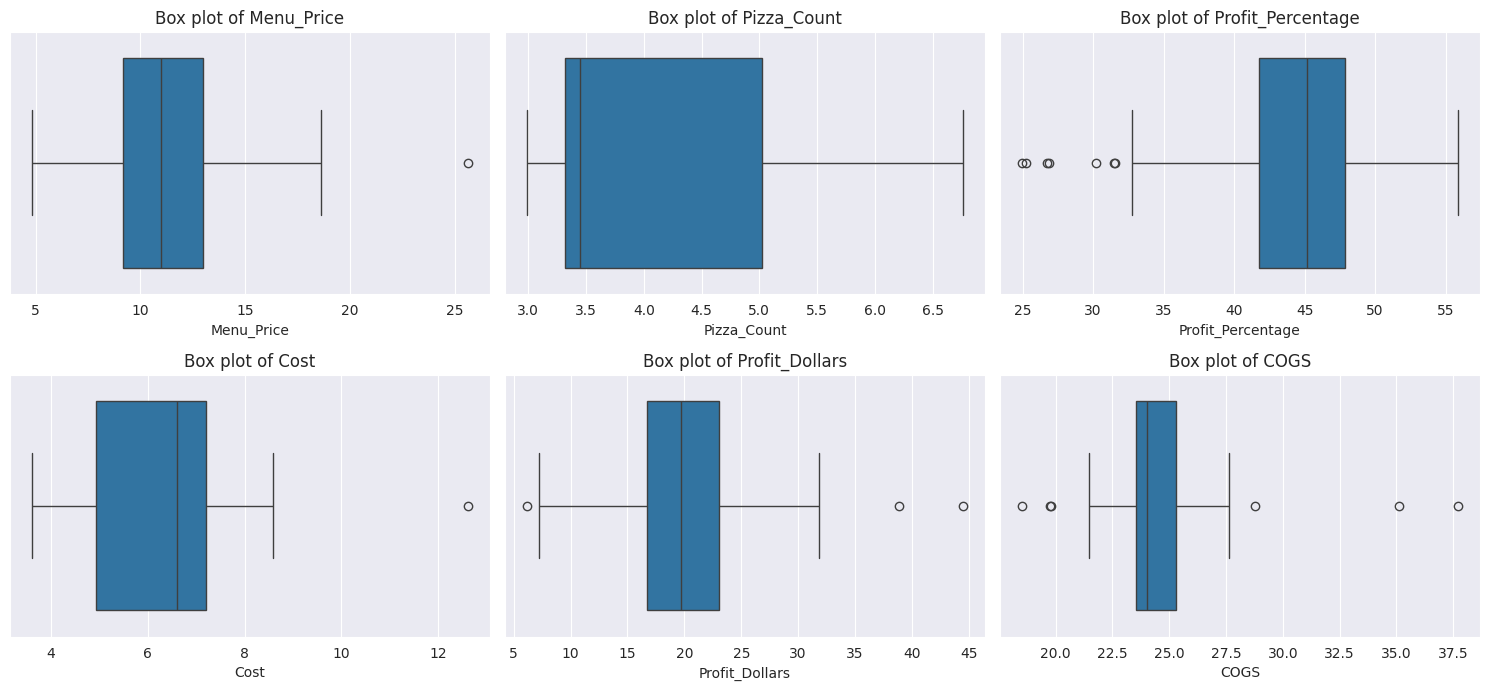

In [341]:
# Box plots
plt.figure(figsize=(15, 10))

for i, column in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df[column])
    plt.title(f'Box plot of {column}')
    plt.xlabel(column)

plt.tight_layout()
plt.show()

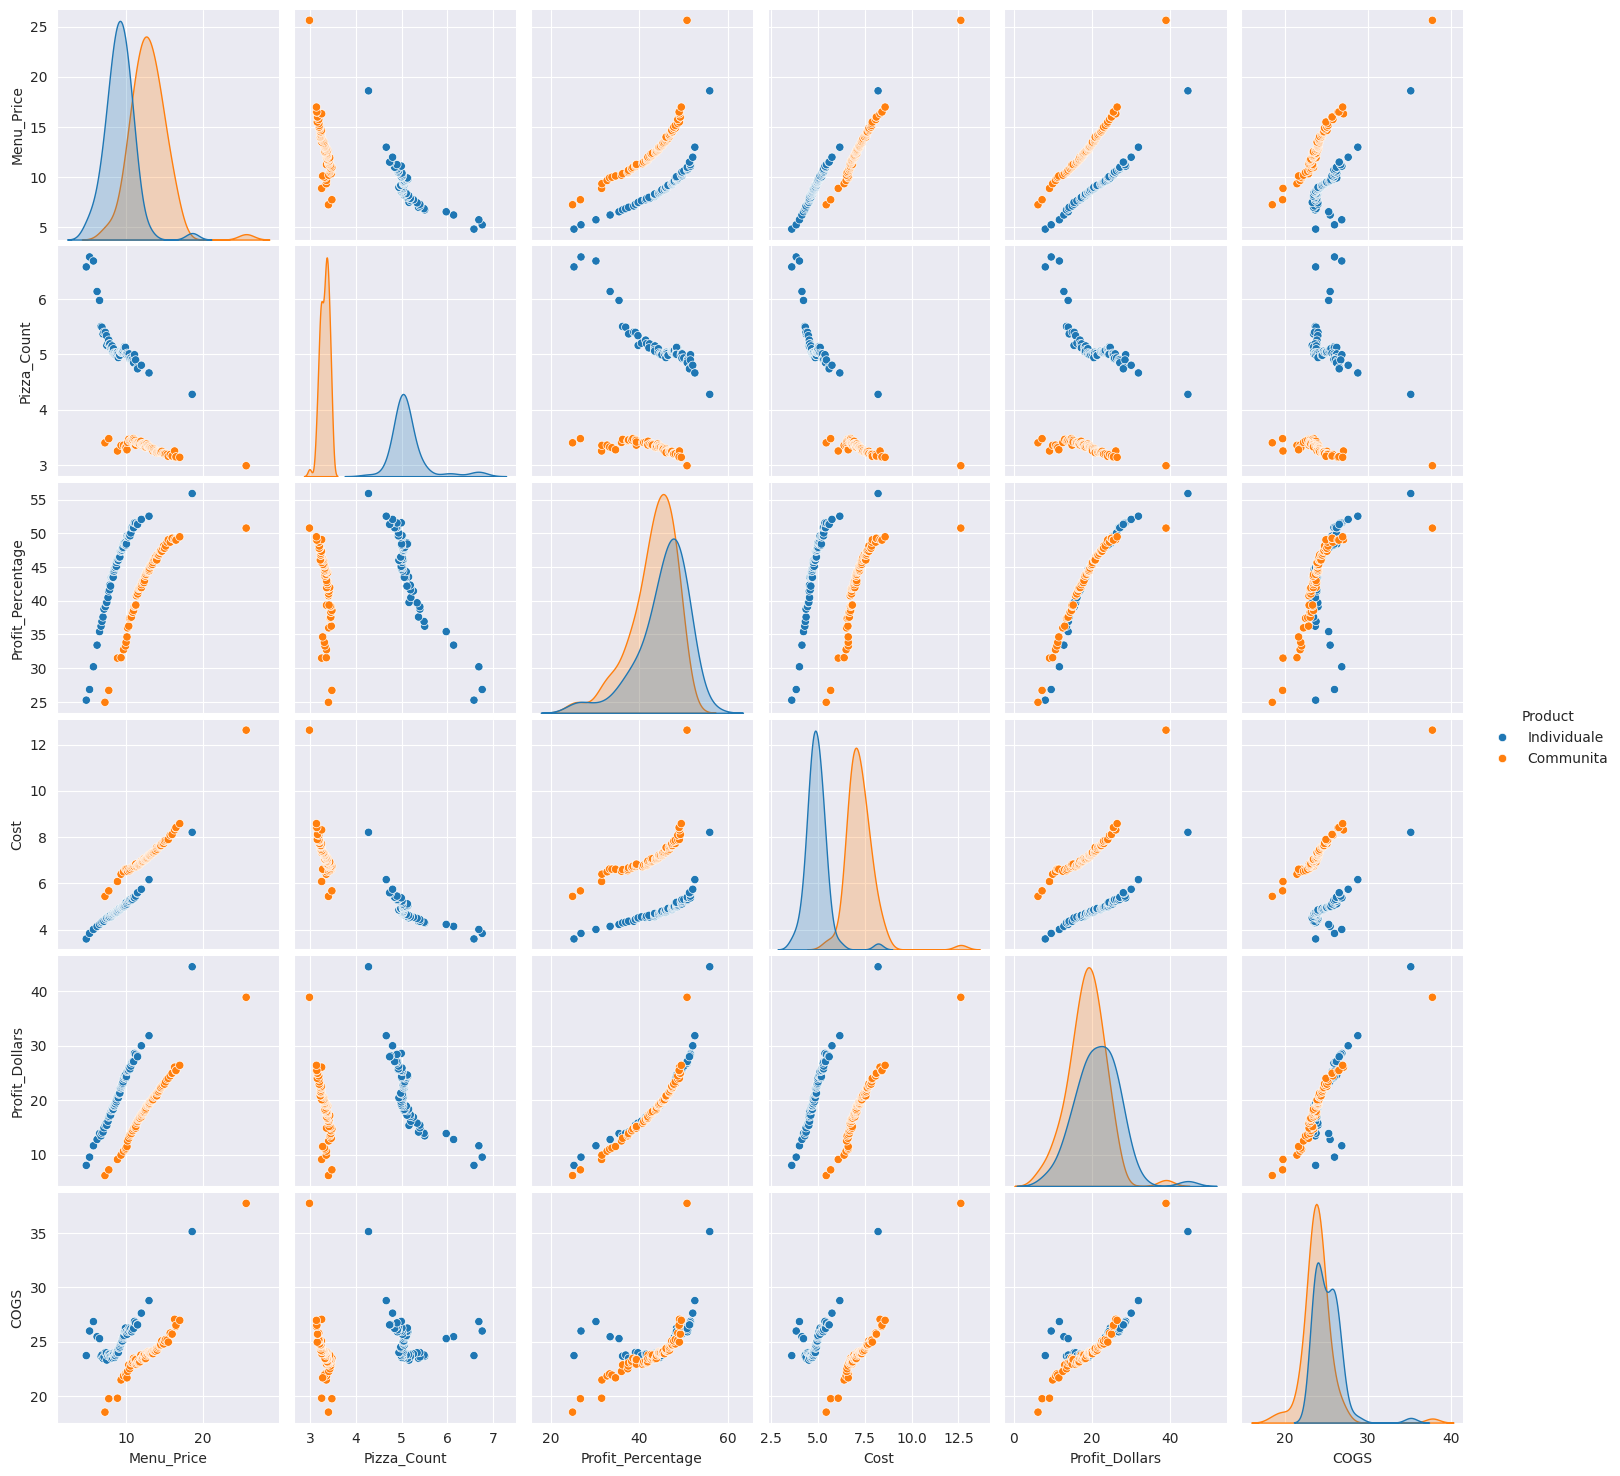

In [342]:
# Pair plots to see relationships and outliers
sns.pairplot(df, hue='Product')
plt.show()

/tmp/ipykernel_513828/1675347469.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profit_and_cogs, x='Product', y='Profit_Dollars', palette='viridis')


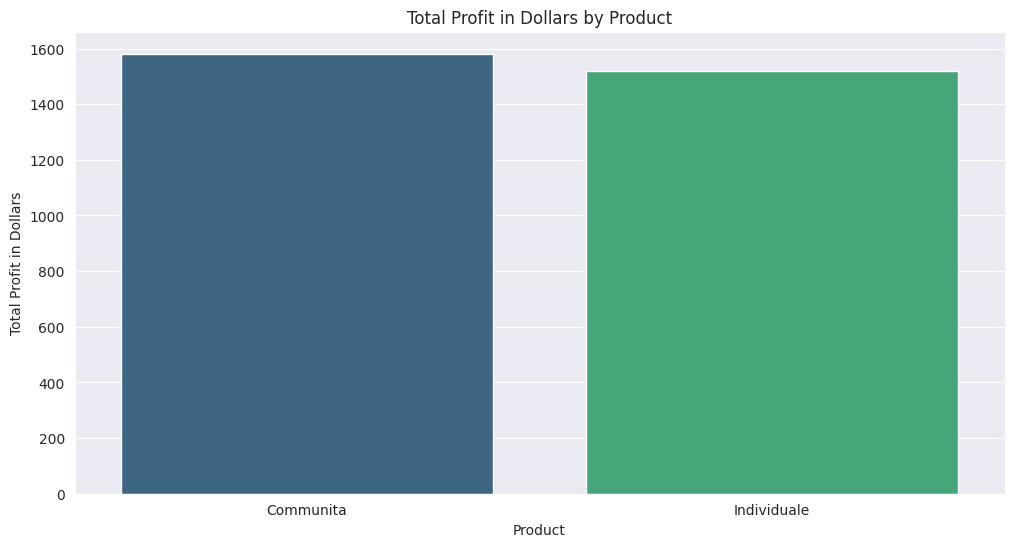

In [343]:
# Total Profit
plt.figure(figsize=(12, 6))
sns.barplot(data=profit_and_cogs, x='Product', y='Profit_Dollars', palette='viridis')
plt.title('Total Profit in Dollars by Product')
plt.xlabel('Product')
plt.ylabel('Total Profit in Dollars')
plt.show()

/tmp/ipykernel_513828/1737958879.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=profit_and_cogs, x='Product', y='COGS', palette='viridis')


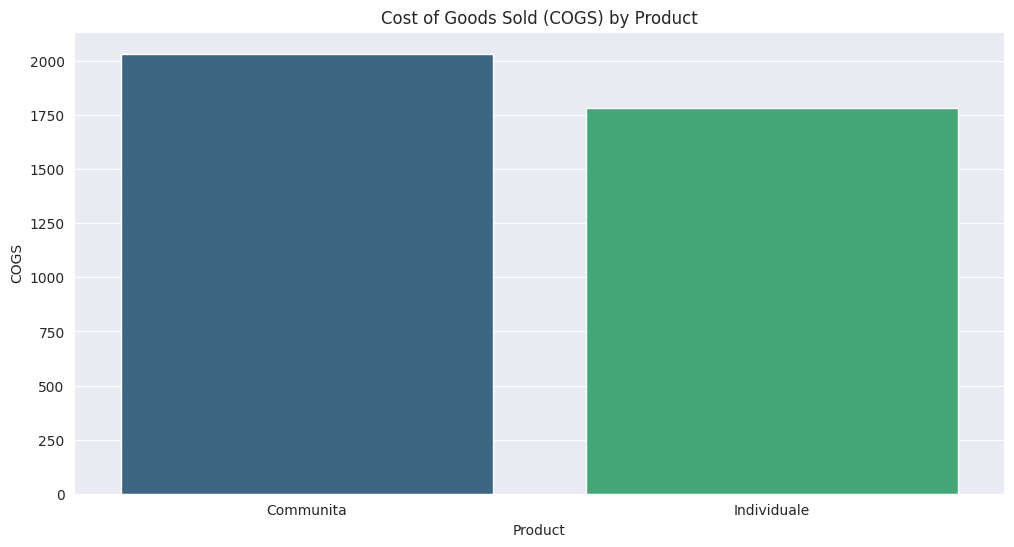

In [344]:
# COGS
plt.figure(figsize=(12, 6))
sns.barplot(data=profit_and_cogs, x='Product', y='COGS', palette='viridis')
plt.title('Cost of Goods Sold (COGS) by Product')
plt.xlabel('Product')
plt.ylabel('COGS')
plt.show()

## price vs Quantity

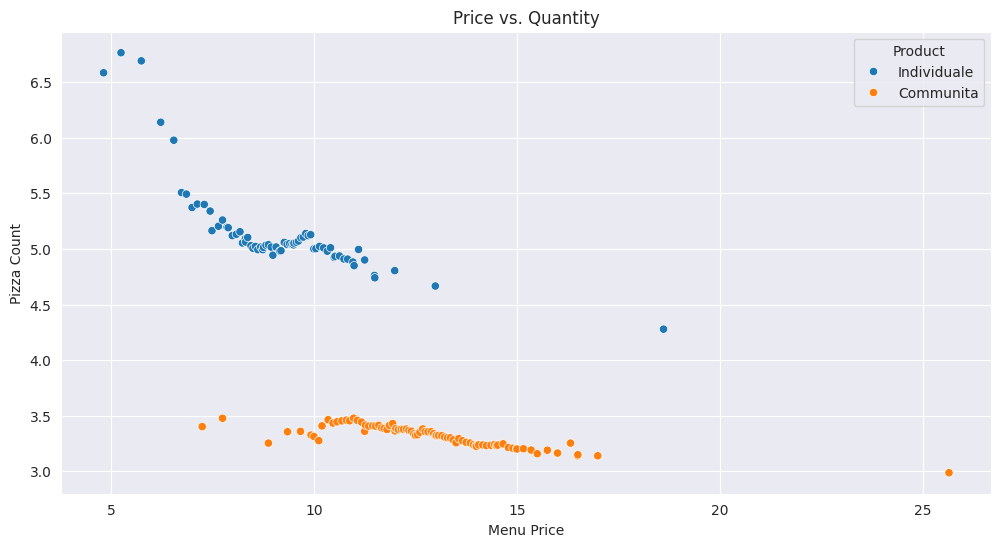

In [345]:
# Scatter plot for Price vs. Pizza Count
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Menu_Price', y='Pizza_Count', hue='Product')
plt.title('Price vs. Quantity')
plt.xlabel('Menu Price')
plt.ylabel('Pizza Count')
plt.legend(title='Product')
# plt.savefig('price_vs_pizza_count.png')
plt.show()

## Price vs Gross Margin

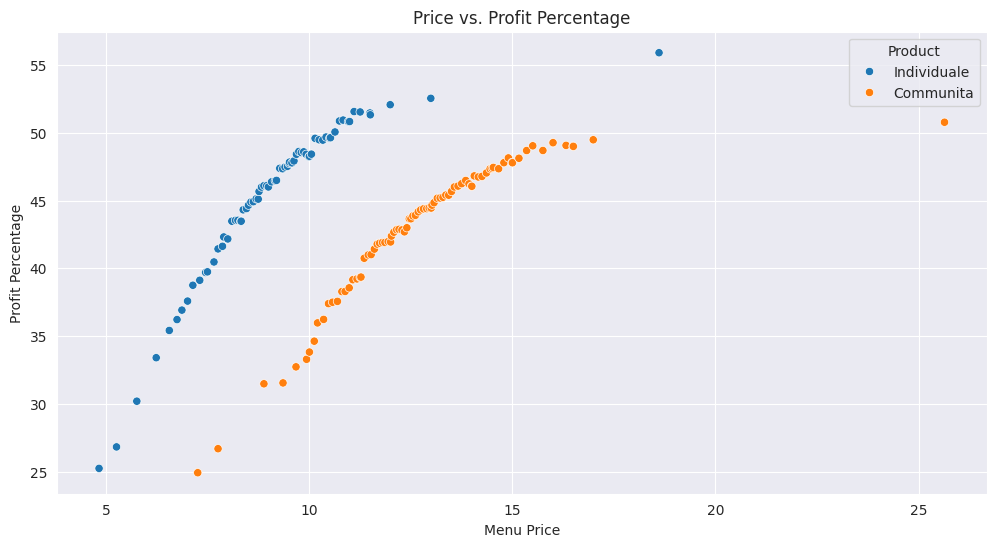

In [346]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x='Menu_Price', y='Profit_Percentage', hue='Product')
plt.title('Price vs. Profit Percentage')
plt.xlabel('Menu Price')
plt.ylabel('Profit Percentage')
plt.legend(title='Product')
# plt.savefig('price_vs_profit_percentage.png')
plt.show()

## pairplot

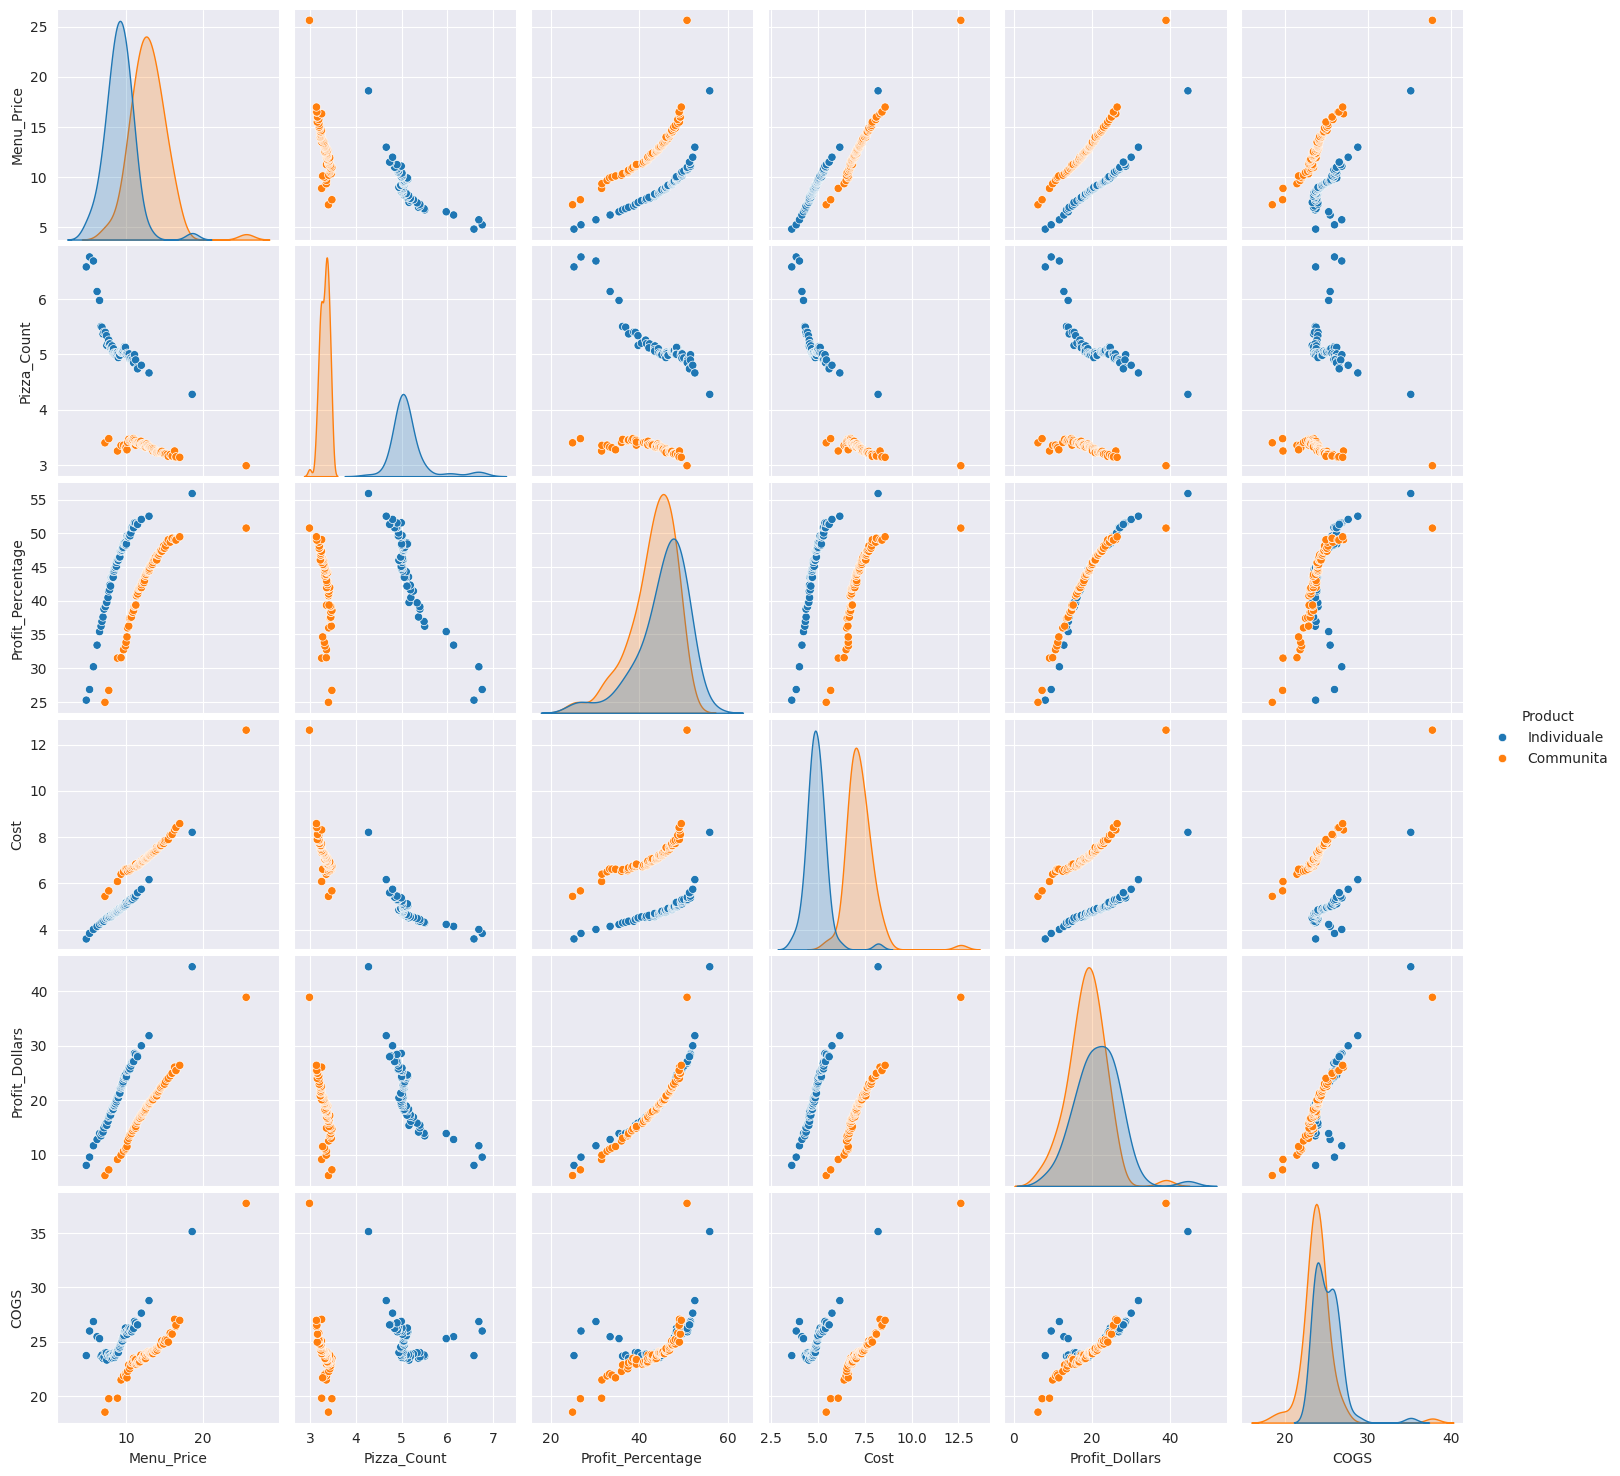

In [347]:
sns.pairplot(df, hue='Product')
plt.show()

Correlation Analysis

In [348]:
# Calculate the correlation matrix
correlation_matrix = df[numerical_cols].corr()
correlation_matrix

,Menu_Price,Pizza_Count,Profit_Percentage,Cost,Profit_Dollars,COGS
Menu_Price,1.000000,-0.753712,0.520991,0.941765,0.554450,0.466864
Pizza_Count,-0.753712,1.000000,-0.028170,-0.899245,0.046349,0.199134
Profit_Percentage,0.520991,-0.028170,1.000000,0.224797,0.930571,0.642408
Cost,0.941765,-0.899245,0.224797,1.000000,0.250477,0.219135
Profit_Dollars,0.554450,0.046349,0.930571,0.250477,1.000000,0.850893
COGS,0.466864,0.199134,0.642408,0.219135,0.850893,1.000000


## correlation analysis

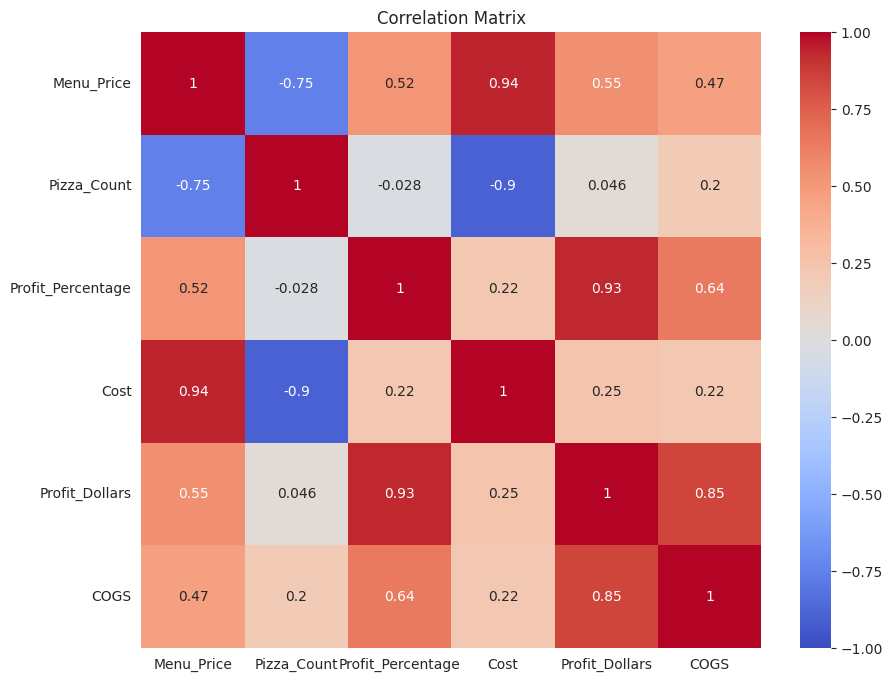

In [349]:
# Visualization of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

## Profit analysis

Product
Communita      1581.318418
Individuale    1518.688013
Name: Total_Profit, dtype: float64


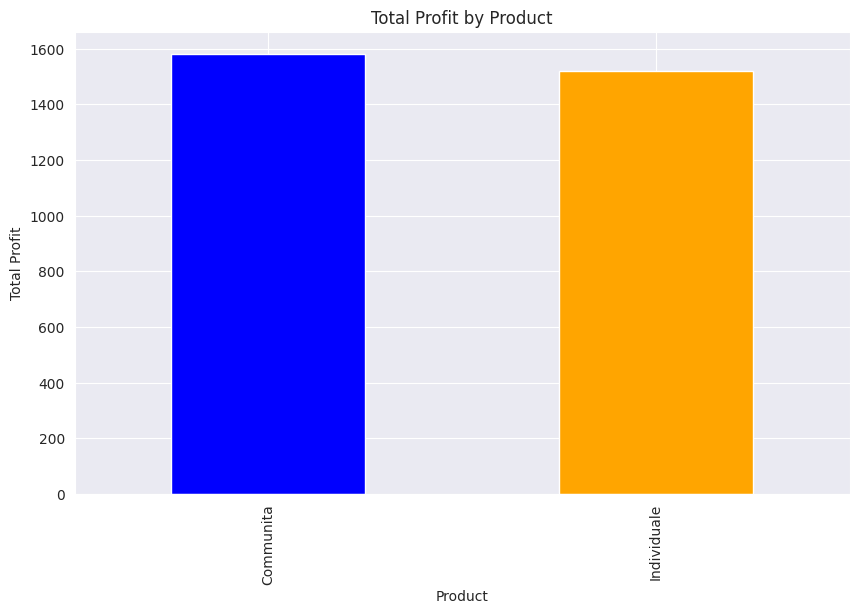

In [350]:
# Calculate total profit for each product
df['Total_Profit'] = df['Pizza_Count'] * (df['Profit_Percentage'] / 100) * df['Menu_Price']

# Group by product and calculate total profit
total_profit = df.groupby('Product')['Total_Profit'].sum()

# Display the total profit for each product
print(total_profit)

# Bar plot for total profit
total_profit.plot(kind='bar', figsize=(10, 6), color=['blue', 'orange'])
plt.title('Total Profit by Product')
plt.xlabel('Product')
plt.ylabel('Total Profit')
plt.show()

Price Elasticity Calculation
Define a function to calculate price elasticity

In [351]:
# Function to calculate price elasticity of demand
def calculate_price_elasticity(data, product):
    product_data = data[data['Product'] == product].copy()
    product_data['Price_Change'] = product_data['Menu_Price'].pct_change()
    product_data['Quantity_Change'] = product_data['Pizza_Count'].pct_change()
    product_data['Elasticity'] = product_data['Quantity_Change'] / product_data['Price_Change']
    product_data.dropna(inplace=True)  # Drop NA values resulting from pct_change
    return product_data

In [352]:
# Calculate price elasticity for 'Individuale' and 'Communita'
individuale_data = calculate_price_elasticity(df, 'Individuale')
communita_data = calculate_price_elasticity(df, 'Communita')

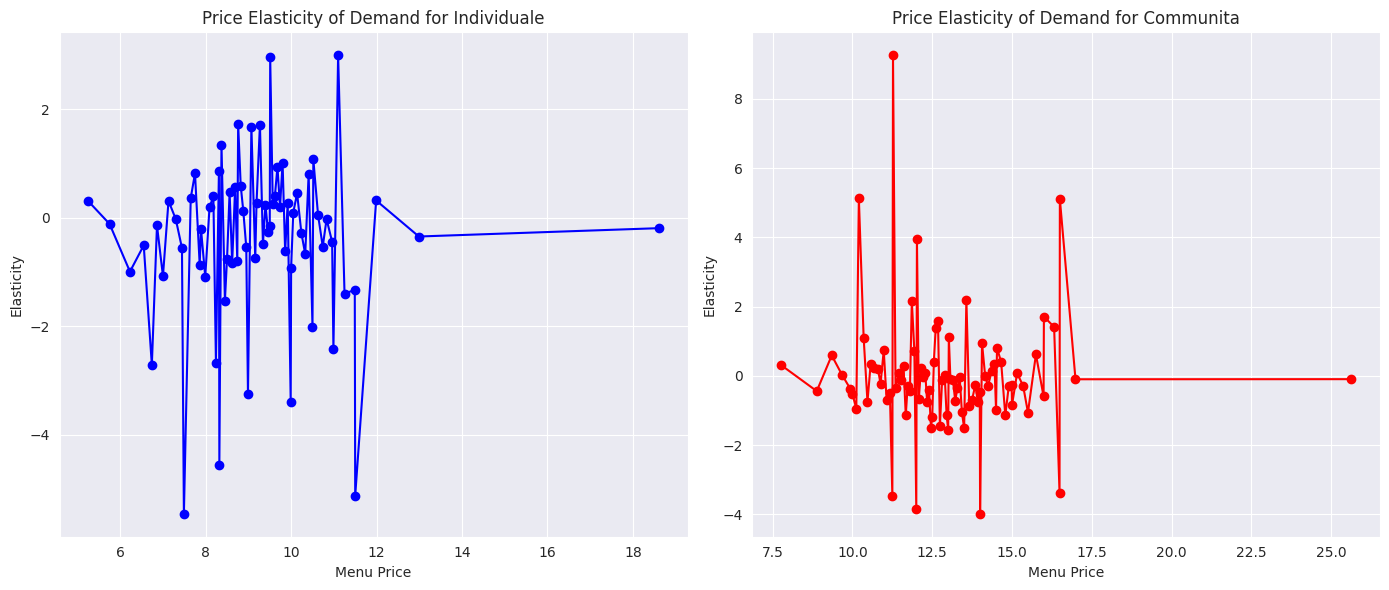

In [353]:
# Plot the price elasticity of demand
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(individuale_data['Menu_Price'], individuale_data['Elasticity'], marker='o', linestyle='-', color='b')
plt.title('Price Elasticity of Demand for Individuale')
plt.xlabel('Menu Price')
plt.ylabel('Elasticity')

plt.subplot(1, 2, 2)
plt.plot(communita_data['Menu_Price'], communita_data['Elasticity'], marker='o', linestyle='-', color='r')
plt.title('Price Elasticity of Demand for Communita')
plt.xlabel('Menu Price')
plt.ylabel('Elasticity')

plt.tight_layout()
plt.show()

outliers?


should we calculate elasticity after log transformation?

In [354]:
# Display the calculated elasticities
print("Individuale Price Elasticity of Demand:")
print(individuale_data[['Menu_Price', 'Elasticity']])

Individuale Price Elasticity of Demand:
    Menu_Price  Elasticity
1       5.2500    0.306721
2       5.7500   -0.113641
3       6.2275   -0.992981
4       6.5500   -0.508653
5       6.7400   -2.713753
..         ...         ...
66     11.4900   -1.329534
67     11.5000   -5.121411
68     11.9900    0.318409
69     12.9900   -0.345740
70     18.6100   -0.191971

[70 rows x 2 columns]


In [355]:
print("\nCommunita Price Elasticity of Demand:")
print(communita_data[['Menu_Price', 'Elasticity']])


Communita Price Elasticity of Demand:
     Menu_Price  Elasticity
72         7.75    0.320040
73         8.88   -0.440373
74         9.35    0.590541
75         9.67    0.033914
76         9.93   -0.371063
..          ...         ...
151       16.32    1.414679
152       16.49   -3.381420
153       16.50    5.111076
154       16.99   -0.098234
155       25.64   -0.095230

[84 rows x 2 columns]


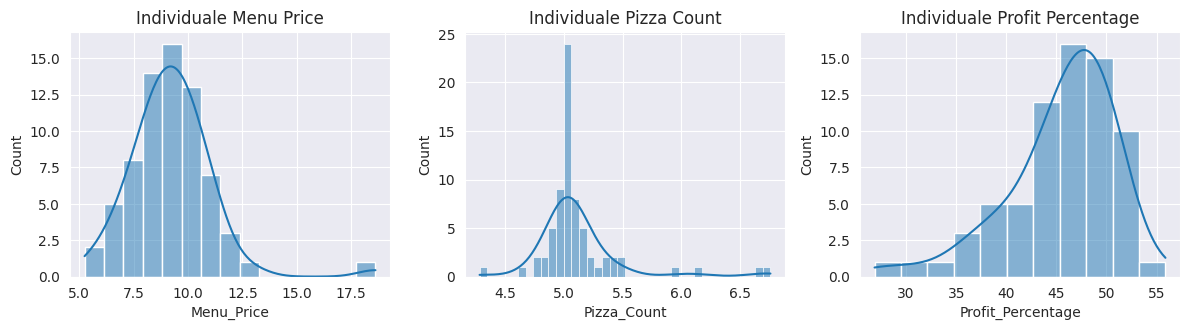

In [356]:
# Histograms for Individuale
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
sns.histplot(individuale_data['Menu_Price'], kde=True)
plt.title('Individuale Menu Price')

plt.subplot(2, 3, 2)
sns.histplot(individuale_data['Pizza_Count'], kde=True)
plt.title('Individuale Pizza Count')

plt.subplot(2, 3, 3)
sns.histplot(individuale_data['Profit_Percentage'], kde=True)
plt.title('Individuale Profit Percentage')

plt.tight_layout()
plt.show()

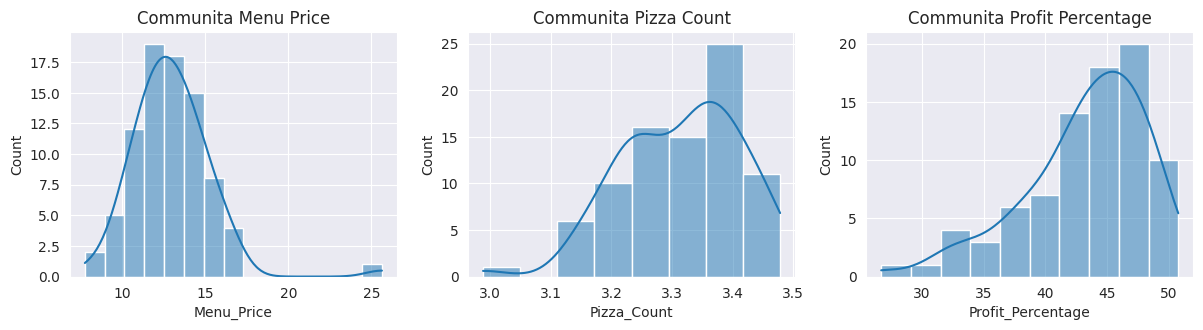

In [357]:
# Histograms for Communita
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 4)
sns.histplot(communita_data['Menu_Price'], kde=True)
plt.title('Communita Menu Price')

plt.subplot(2, 3, 5)
sns.histplot(communita_data['Pizza_Count'], kde=True)
plt.title('Communita Pizza Count')

plt.subplot(2, 3, 6)
sns.histplot(communita_data['Profit_Percentage'], kde=True)
plt.title('Communita Profit Percentage')

plt.tight_layout()
plt.show()

In [358]:
# Apply the function to each DataFrame
individuale_data = calculate_price_elasticity(individuale_data, 'Individuale')
communita_data = calculate_price_elasticity(communita_data, 'Communita')

In [359]:
# Concatenate the results
data = pd.concat([individuale_data, communita_data])

In [360]:
# todo: calculate cost of goods sold and add new vector

In [361]:
# Reset index to clean up the DataFrame
data.reset_index(drop=True, inplace=True)
data

,Product,Menu_Price,Pizza_Count,Profit_Percentage,Cost,Profit_Dollars,COGS,Total_Profit,Price_Change,Quantity_Change,Elasticity
0,Individuale,5.7500,6.690481,30.214454,4.012669,11.623581,26.846686,11.623581,0.095238,-0.010823,-0.113641
1,Individuale,6.2275,6.138780,33.417930,4.146398,12.775426,25.453829,12.775426,0.083043,-0.082461,-0.992981
2,Individuale,6.5500,5.977077,35.425975,4.229599,13.869217,25.280635,13.869217,0.051786,-0.026341,-0.508653
3,Individuale,6.7400,5.506564,36.226450,4.298337,13.445171,23.669069,13.445171,0.029008,-0.078720,-2.713753
4,Individuale,6.8600,5.492654,36.924465,4.326982,13.912992,23.766611,13.912992,0.017804,-0.002526,-0.141884
...,...,...,...,...,...,...,...,...,...,...,...
147,Communita,16.3200,3.254308,49.061000,8.313245,26.056444,27.053856,26.056444,0.020000,0.028294,1.414679
148,Communita,16.4900,3.139681,49.011439,8.408014,25.374856,26.398479,25.374856,0.010417,-0.035223,-3.381420
149,Communita,16.5000,3.149412,48.987274,8.417100,25.456384,26.508916,25.456384,0.000606,0.003100,5.111076
150,Communita,16.9900,3.140224,49.472921,8.584551,26.394997,26.957416,26.394997,0.029697,-0.002917,-0.098234


# Linear Regression

In [362]:
# Feature Engineering
data['Price_Squared'] = data['Menu_Price'] ** 2

In [363]:
# Split Data
X = data[['Menu_Price', 'Price_Squared']]
y = data['Pizza_Count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [364]:
# train Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [365]:
# evaluate Model
y_pred = model.predict(X_test)
print('MAE:', mean_absolute_error(y_test, y_pred))
print('MSE:', mean_squared_error(y_test, y_pred))
print('R-squared:', r2_score(y_test, y_pred))

MAE: 0.3955824438722458
MSE: 0.3403998682886883
R-squared: 0.5167313645707543


In [366]:
# Optimal Pricing Strategy
# Predict sales and profit for a range of prices
prices = np.linspace(data['Menu_Price'].min(), data['Menu_Price'].max(), 100)
sales = model.predict(np.c_[prices, prices**2])
profit = sales * prices
optimal_price = prices[np.argmax(profit)]

/home/noone/.cache/pypoetry/virtualenvs/dominos-senior-data-scientist-mPMyyBsO-py3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


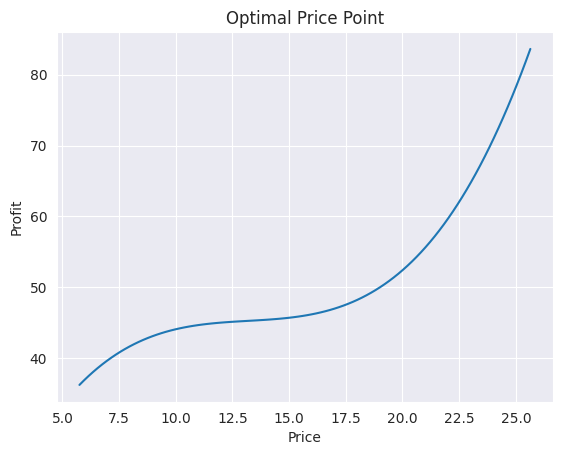

In [367]:
# Plot Optimal Price
plt.plot(prices, profit)
plt.xlabel('Price')
plt.ylabel('Profit')
plt.title('Optimal Price Point')
plt.show()